<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Naming-conventions" data-toc-modified-id="Naming-conventions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Naming conventions</a></span></li><li><span><a href="#Config" data-toc-modified-id="Config-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Config</a></span></li><li><span><a href="#Load-Standards" data-toc-modified-id="Load-Standards-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Standards</a></span></li><li><span><a href="#Load-datas" data-toc-modified-id="Load-datas-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load datas</a></span><ul class="toc-item"><li><span><a href="#Helper-Functions" data-toc-modified-id="Helper-Functions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Helper Functions</a></span></li><li><span><a href="#Animal-emissions" data-toc-modified-id="Animal-emissions-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Animal emissions</a></span><ul class="toc-item"><li><span><a href="#Tables-description" data-toc-modified-id="Tables-description-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Tables description</a></span></li><li><span><a href="#Enteric-Fermentation" data-toc-modified-id="Enteric-Fermentation-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Enteric Fermentation</a></span><ul class="toc-item"><li><span><a href="#Element-Column" data-toc-modified-id="Element-Column-4.2.2.1"><span class="toc-item-num">4.2.2.1&nbsp;&nbsp;</span>Element Column</a></span></li><li><span><a href="#Item-Column" data-toc-modified-id="Item-Column-4.2.2.2"><span class="toc-item-num">4.2.2.2&nbsp;&nbsp;</span>Item Column</a></span></li></ul></li><li><span><a href="#Manure-Soils" data-toc-modified-id="Manure-Soils-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Manure Soils</a></span><ul class="toc-item"><li><span><a href="#Checking-for-null-values" data-toc-modified-id="Checking-for-null-values-4.2.3.1"><span class="toc-item-num">4.2.3.1&nbsp;&nbsp;</span>Checking for null values</a></span></li><li><span><a href="#Element-column" data-toc-modified-id="Element-column-4.2.3.2"><span class="toc-item-num">4.2.3.2&nbsp;&nbsp;</span>Element column</a></span></li><li><span><a href="#Item-column" data-toc-modified-id="Item-column-4.2.3.3"><span class="toc-item-num">4.2.3.3&nbsp;&nbsp;</span>Item column</a></span></li></ul></li><li><span><a href="#Manure-Pasture" data-toc-modified-id="Manure-Pasture-4.2.4"><span class="toc-item-num">4.2.4&nbsp;&nbsp;</span>Manure Pasture</a></span><ul class="toc-item"><li><span><a href="#Checking-for-null-values" data-toc-modified-id="Checking-for-null-values-4.2.4.1"><span class="toc-item-num">4.2.4.1&nbsp;&nbsp;</span>Checking for null values</a></span></li><li><span><a href="#Element-column" data-toc-modified-id="Element-column-4.2.4.2"><span class="toc-item-num">4.2.4.2&nbsp;&nbsp;</span>Element column</a></span></li><li><span><a href="#Item-column" data-toc-modified-id="Item-column-4.2.4.3"><span class="toc-item-num">4.2.4.3&nbsp;&nbsp;</span>Item column</a></span></li></ul></li><li><span><a href="#Manure-Management" data-toc-modified-id="Manure-Management-4.2.5"><span class="toc-item-num">4.2.5&nbsp;&nbsp;</span>Manure Management</a></span><ul class="toc-item"><li><span><a href="#Checking-for-null-values" data-toc-modified-id="Checking-for-null-values-4.2.5.1"><span class="toc-item-num">4.2.5.1&nbsp;&nbsp;</span>Checking for null values</a></span></li><li><span><a href="#Element-Column" data-toc-modified-id="Element-Column-4.2.5.2"><span class="toc-item-num">4.2.5.2&nbsp;&nbsp;</span>Element Column</a></span></li><li><span><a href="#Item-column" data-toc-modified-id="Item-column-4.2.5.3"><span class="toc-item-num">4.2.5.3&nbsp;&nbsp;</span>Item column</a></span></li></ul></li></ul></li><li><span><a href="#Computed-emissions-data" data-toc-modified-id="Computed-emissions-data-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Computed emissions data</a></span></li><li><span><a href="#Productions" data-toc-modified-id="Productions-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Productions</a></span></li><li><span><a href="#Trade-data" data-toc-modified-id="Trade-data-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Trade data</a></span></li></ul></li><li><span><a href="#Products-Filtering" data-toc-modified-id="Products-Filtering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Products Filtering</a></span></li><li><span><a href="#Livestock-food-estimate" data-toc-modified-id="Livestock-food-estimate-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Livestock food estimate</a></span><ul class="toc-item"><li><span><a href="#Beef" data-toc-modified-id="Beef-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Beef</a></span></li><li><span><a href="#Dairy-cattle" data-toc-modified-id="Dairy-cattle-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Dairy cattle</a></span></li><li><span><a href="#Poultry" data-toc-modified-id="Poultry-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Poultry</a></span></li><li><span><a href="#Poultry-(laying-hen)" data-toc-modified-id="Poultry-(laying-hen)-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Poultry (laying hen)</a></span></li><li><span><a href="#Swine" data-toc-modified-id="Swine-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Swine</a></span></li></ul></li></ul></div>

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotmap import DotMap
from pathlib import Path
from collections.abc import Mapping, Iterable

from IPython.display import display

%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Naming conventions

For easier reading, the following naming conventions are used. The templates are written as shell file template

+ `df_*` denotes an pandas.DataFrame
+ `dfs_*` denotes any dict-like mapping from names to pandas.DataFrame

Those naming conventions also holds for helper function signatures

# Config

In [2]:
DATA = Path("./data")

# Load Standards

Flags provide additional info on how the values in datasets where obtained

In [3]:
df_flags = pd.read_csv(
    DATA / "definitions_and_standards/flags.csv",
    keep_default_na=False,
    index_col="Flag"
)

The same country code are used in all of FAOSTAT datasets. As datasets contains aggregated data on country groups, loading that dataframe will allow to remove aggregated data.

In [4]:
df_area_groups = pd.read_csv(
    DATA / "definitions_and_standards/country_group.csv"
)

# Load datas

## Helper Functions

In [5]:
# Helper function

#snake case conversion
_first_cap_re = re.compile("(\w)([A-Z][a-z]+)")
_all_cap_re = re.compile("([a-z0-9])([A-Z])")
_space_between = re.compile("(\W*) ([a-z]*)")


def to_snakecase(name):
    s1 = _first_cap_re.sub(r"\1_\2", name)
    s2 = _all_cap_re.sub(r"\1_\2", s1).lower()
    s3 = _space_between.sub(r"\1_\2", s2)
    return s3.replace(" ", "").replace("__", "_")

def join_flags(df, filepath, df_flags):
    df["Flag"] = pd.read_csv(filepath, encoding="latin1", usecols=["Flag"], keep_default_na=False)
    return df.merge(df_flags, on="Flag").drop(columns="Flag").rename(columns={"Flags": "Flag"})

def load_df(filepath, join_df_flags=None, encoding="latin1"):
    """
    Function for quick loading of dataframes. Use the correct encoding and reloads the Flags column
    if th dataframe of the flags is provided
    """
    df = pd.read_csv(filepath, encoding=encoding)
    if join_df_flags is not None:
        df = join_flags(df, filepath, join_df_flags)
    return df

def split_on(df, column, rename={}, only_named=False, drop=[]):
    """
    Splits a dataframe in multiple dataframe based on the value of a columne
    
    Args:
        df: dataframe to spli
        column: name of the column to split on
        rename (optional): mapping or callable that rename values to name in the final dictionary
        only_named (False): keep only dataframe with a value in column that is renamed
        drop: drop columns in resulting dataframes (useful for redundant columns)
    
    Returns:
        A dictionnary mapping unique values in df[column] to the dataframe with that value.
        Value (i.e. dict keys) can be renamed by the rename argument. A callable can return None to not rename it.
    """
    result = DotMap(_dynamic=False)
    if not isinstance(drop, Iterable) or isinstance(drop, str):
        drop = [drop]
    for value in df[column].unique():
        if callable(rename):
            name = rename(value)
        elif isinstance(rename, Mapping):
            name = rename.get(value)
        else:
            name = None
        if name is None and only_named:
            continue
        result[name or value] = df[ df[column] == value].drop(columns=drop + [column])
    return result

def select_on(df, column_filter_dict):
    """
    Filter some columns of the DataFrame for values in the provided list. Equivalent to as sequence
    of isin() calls
    
    Args:
        df: the dataframe to filter
        column_value_filter_dict: a mapping from column names to the list of value to keep
    
    Returns:
        The filtered dataframe
    """
    for column, values in column_filter_dict.items():
        df = df[ df[column].isin(values) ]
    return df


def remove_country_group(df, df_area_code=None):
    """
    Remove all entries in the DataFrame for group of countries (e.g. Asia)

    Args:
        df: the DataFrame to filter
        df_area_code: dataframe from the standards, indicating which countries are in which country group
            If not provided, defaults to removing Area Code >= 5000 (see note)
    
    Returns:
        A filtered DataFrame
    
    Note:
        It appears all country-group use "Area Code" >= 5000.
        However, this is not guaranteed so we prefere to use the standars to get country group code
    """
    if df_area_code is not None:
        return df[~df["Area Code"].isin(df_area_code["Country Group Code"])]
    else:
        return df[ df["Area Code"] < 5000]

def plot_completeness_histogram(df_or_dfs, ax=None, figsize=None, agg_on="Area Code"):
    """
    Plot the histogram of how many unique area_code provide data for each year. Used
    to get an idea on how complete the data are


    Args:
        df_or_dfs: the dataframe to plot the completeness histogram of
            OR a mapping from names to dataframes
        ax: matplotlib Axis to draw on
    Returns:
        None. Plot the afformention histogram
    """
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    if isinstance(df_or_dfs, Mapping):
        pd.DataFrame(
            {
                name: df.groupby("Year")[agg_on].nunique()
                for name, df in df_or_dfs.items()
            }
        ).plot.bar(ax=ax)
        ax.legend()
    else:
        df_or_dfs.groupby("Year")[agg_on].nunique().plot.bar(ax=ax)
    ax.set_xlabel("Year")
    ax.set_ylabel("# of countries with available data")
    ax.set_title("Evolution of data completeness")
    return ax

## Animal emissions

Load necessary dataframes and join with the flags dataframe. The "Year Code" column is redundant with the "Year" column, so we drop it

In [6]:
df_enteric_fermentation = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Emissions_Agriculture_Enteric_Fermentation_E_All_Data_(Norm).csv",
    df_flags
).drop(columns="Year Code")

df_manure_soils = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Emissions_Agriculture_Manure_applied_to_soils_E_All_Data_(Norm).csv",
    df_flags
).drop(columns="Year Code")

df_manure_management = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Emissions_Agriculture_Manure_Management_E_All_Data_(Norm).csv",
    df_flags
).drop(columns="Year Code")

df_manure_pasture = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Emissions_Agriculture_Manure_left_on_pasture_E_All_Data_(Norm).csv",
    df_flags
).drop(columns="Year Code")

### Tables description

Each of the 4 tables have the same columns, which are described below:

In [7]:
df_enteric_fermentation.columns

Index(['Country Code', 'Country', 'Item Code', 'Item', 'Element Code',
       'Element', 'Year', 'Unit', 'Value', 'Flag'],
      dtype='object')


- **Country code**: unique identifier of countries
- **Country**
- **Item**: Animal
- **Item Code**: unique identifier of Animal
- **Element**: type of GHG(Greenhouse gaz) emission / Stock
- **Element Code**: unique identifier of the type of emission
- **Year**
- **Unit**: Unit of Element
- **Value**: Value of Element
- **Flag**: Origin of the data
 


For each of these 4 tables we will start by cleaning and preprocessing the data, then do a quick analysis of the livestock species(asses, buffaloes, camels...) to see the animals that produce the most emissions in the world first by the total number of livestock species then only by head. 

### Enteric Fermentation
The table ‘Enteric Fermentation’ contains the following data:
country-level GHG(Greenhouse gaz) emissions in both Gg CH4 and Gg CO2eq, by animal categories and their aggregates, as well as their total; implied emission factors; and activity data.

In [8]:
df_enteric_fermentation.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,Head,1300000.0,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,Head,851850.0,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,Head,1001112.0,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,Head,1300000.0,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,Head,1200000.0,Official data


In [9]:
df_enteric_fermentation.isna().any()

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year            False
Unit            False
Value           False
Flag            False
dtype: bool

No null values in this table

In [10]:
print("Unique years :\n",df_enteric_fermentation["Year"].unique())
print()
print("Unique flags :\n",df_enteric_fermentation["Flag"].unique())

Unique years :
 [1961 1962 1963 1965 1966 1967 1968 1969 1970 1971 1972 1977 1987 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 1978 1979 1980 1981 1982 1986 1973 1974 1975 1976 1995 1998 1991
 1997 1988 1989 1990 1964 1992 1993 1994 1996 1985 1983 1984 2030 2050]

Unique flags :
 ['Official data' 'FAO estimate' 'Unofficial figure' 'Calculated data'
 'Aggregate, may include official, semi-official, estimated or calculated data'
 'FAO data based on imputation methodology']


In [11]:
#Removing predictions of future years
df_enteric_fermentation = df_enteric_fermentation[df_enteric_fermentation["Year"] < 2030]

#Description of Element column
df_enteric_fermentation["Element"].unique()

array(['Stocks', 'Implied emission factor for CH4 (Enteric)',
       'Emissions (CH4) (Enteric)', 'Emissions (CO2eq) (Enteric)'],
      dtype=object)

In the *Element* column we will only be interested in the value of *Stocks* which corresponds to the total number of livestock species(asses, buffaloes, camels...) and the value of *Emissions (CO2eq) (Enteric)* which corresponds to the total aggregate of the GHG emission in CO2eq

#### Element Column 

In [12]:
#Filter the Element Column
dfs_enteric_fermentation = split_on(
    df_enteric_fermentation[
        df_enteric_fermentation["Element"].isin(["Stocks","Emissions (CO2eq) (Enteric)"])
    ],
    column="Element",
    rename={
        "Stocks": "stocks",
        "Emissions (CO2eq) (Enteric)": "emissions"
    }
)

print("Stock unit :", dfs_enteric_fermentation.stocks["Unit"].unique())
print("Emission unit :", dfs_enteric_fermentation.emissions["Unit"].unique())

Stock unit : ['Head']
Emission unit : ['Gigagrams']


#### Item Column

We keep only data aggregated on the whole world.

In [13]:
print(df_enteric_fermentation["Item"].unique())

Animals = df_enteric_fermentation["Item"].unique()

column_filters = {
    "Country" : ["World"],
    "Item" : Animals
}

dfs_enteric_fermentation_filtered = DotMap(_dynamic=False)
dfs_enteric_fermentation_filtered["stocks"] = select_on(
    dfs_enteric_fermentation.stocks,
    column_filter_dict=column_filters
)

dfs_enteric_fermentation_filtered["emissions"] = select_on(
    dfs_enteric_fermentation.emissions,
    column_filter_dict=column_filters
)

['Asses' 'Camels' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes'
 'Cattle, dairy' 'Cattle, non-dairy' 'Swine, breeding' 'Swine, market'
 'Llamas' 'All Animals' 'Camels and Llamas' 'Cattle' 'Mules and Asses'
 'Sheep and Goats' 'Swine']


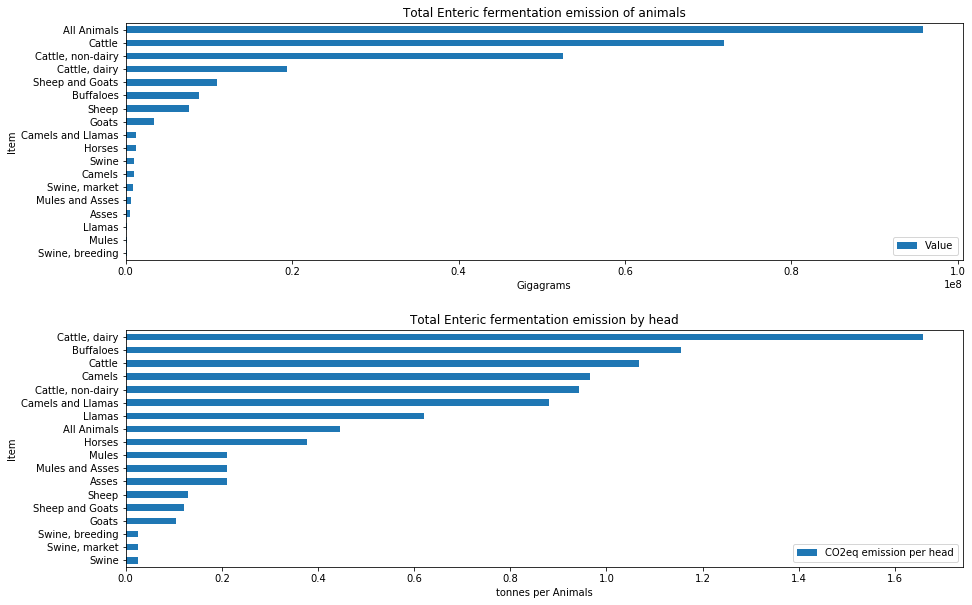

In [14]:
#Grouping stocks count
df_enteric_fermentation_stock_grouped = (
    dfs_enteric_fermentation_filtered["stocks"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

#Grouping total emissions count
df_enteric_fermentation_emission_grouped = (
    dfs_enteric_fermentation_filtered["emissions"]
    .groupby(["Item"])
    ['Value']
    .sum()
    .reset_index()
)

#Merged to get emissions by head
df_enteric_merged = df_enteric_fermentation_emission_grouped.merge(
    df_enteric_fermentation_stock_grouped,
    on="Item",
    suffixes=("_emission", "_stock")
)

# Convert to tonnes per Animal
df_enteric_merged["CO2eq emission per head"] = df_enteric_merged["Value_emission"] / df_enteric_merged["Value_stock"] * 1000

fig, axes = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)

df_enteric_fermentation_emission_grouped.sort_values("Value").plot.barh(
    "Item",
    title="Total Enteric fermentation emission of animals",
    ax=axes[0]
)
axes[0].set_xlabel("Gigagrams")
axes[0].legend(loc="lower right")

df_enteric_merged.sort_values("CO2eq emission per head").plot.barh(
    x="Item",
    y="CO2eq emission per head",
    title="Total Enteric fermentation emission by head",
    ax=axes[1]
)
axes[1].set_xlabel("tonnes per Animals")
axes[1].legend(loc="lower right")

### Manure Soils
The table ‘Manure applied to Soils’ contains the following data:


GHG emissions from manure applied to soils consisting of direct and indirect nitrous oxide (N2O) emissions from manure nitrogen (N) added to agricultural soils by farmers.

In [15]:
df_manure_soils.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,Head,1300000.0,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,Head,851850.0,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,Head,1001112.0,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,Head,1300000.0,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,Head,1200000.0,Official data


#### Checking for null values

In [16]:
print(df_manure_soils.isna().any())
print("Array of years will null values :", df_manure_soils[df_manure_soils["Value"].isna()]["Year"].unique())

#Removing null values(only in predictions)
df_manure_soils = df_manure_soils[df_manure_soils["Year"]<2030]

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year            False
Unit            False
Value            True
Flag            False
dtype: bool
Array of years will null values : [2030 2050]


#### Element column

In [17]:
df_manure_soils["Element"].unique()

array(['Stocks', 'Manure (N content) (Manure applied)',
       'Implied emission factor for N2O (Manure applied)',
       'Direct emissions (N2O) (Manure applied)',
       'Direct emissions (CO2eq) (Manure applied)',
       'Indirect emissions (N2O) (Manure applied)',
       'Indirect emissions (CO2eq) (Manure applied)',
       'Emissions (N2O) (Manure applied)',
       'Emissions (CO2eq) (Manure applied)'], dtype=object)

Similarly to the previous table, in the *Element* column we will only be interested in the value of *Stocks* and the value of *Emissions (CO2eq) (Manure applied)* which corresponds to the total aggregate of the GHG emission in CO2eq

In [18]:
#Filter the Element Column
dfs_manure_soils = split_on(
    df_manure_soils[
        df_manure_soils["Element"].isin(["Emissions (CO2eq) (Manure applied)", "Stocks"])
    ],
    column="Element",
    rename={
        "Stocks": "stocks",
        "Emissions (CO2eq) (Manure applied)": "emissions"
    }
)

print("Stock unit :", dfs_manure_soils.stocks["Unit"].unique())
print("Emission unit :", dfs_manure_soils.emissions["Unit"].unique())

Stock unit : ['Head']
Emission unit : ['Gigagrams']


#### Item column

We keep only data aggregated on the whole world.

In [19]:
print(df_manure_soils["Item"].unique())

Animals = df_manure_soils["Item"].unique()

column_filters = {
    "Country" : ["World"],
    "Item" : Animals
}

dfs_manure_soils_filtered = DotMap(_dynamic=False)
dfs_manure_soils_filtered["stocks"] = select_on(
    dfs_manure_soils["stocks"],
    column_filter_dict=column_filters
)
dfs_manure_soils_filtered["emissions"] = select_on(
    dfs_manure_soils["emissions"],
    column_filter_dict=column_filters
)

['Asses' 'Camels' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes' 'Ducks'
 'Turkeys' 'Cattle, dairy' 'Cattle, non-dairy' 'Chickens, broilers'
 'Chickens, layers' 'Swine, breeding' 'Swine, market' 'Llamas'
 'All Animals' 'Camels and Llamas' 'Cattle' 'Chickens' 'Mules and Asses'
 'Poultry Birds' 'Sheep and Goats' 'Swine']


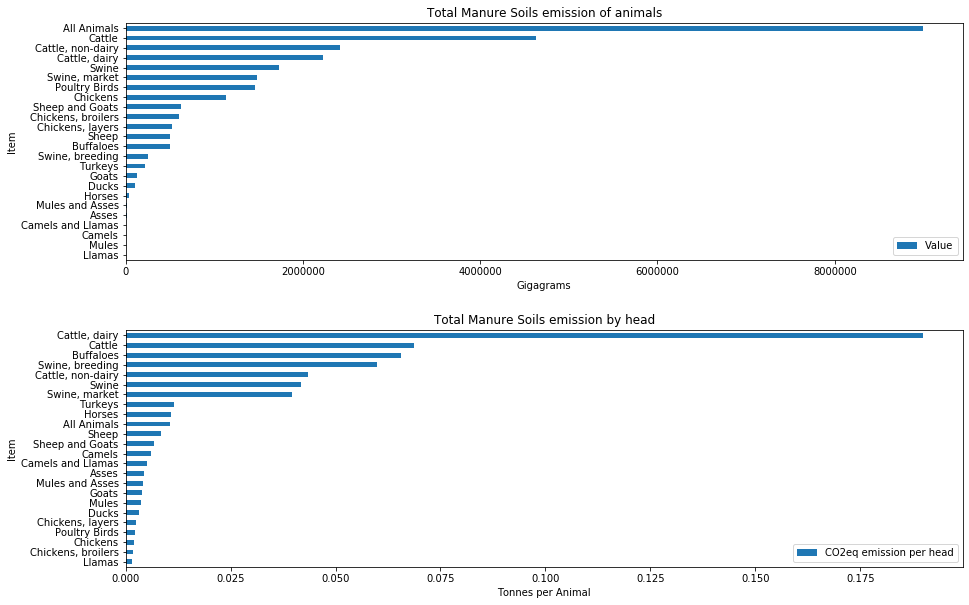

In [20]:
#Grouping stocks count
df_manure_soils_stocks_grouped = (
    dfs_manure_soils_filtered["stocks"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_manure_soils_emission_grouped = (
    dfs_manure_soils_filtered["emissions"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_manure_merged = df_manure_soils_emission_grouped.merge(
    df_manure_soils_stocks_grouped,
    on="Item",
    suffixes=("_emissions", "_stocks")
)

# Convert to tonnes per Animal
df_manure_merged["CO2eq emission per head"] = df_manure_merged["Value_emissions"] / df_manure_merged["Value_stocks"] * 1000

fig, axes = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)

df_manure_soils_emission_grouped.sort_values("Value").plot.barh(
    "Item",
    title="Total Manure Soils emission of animals",
    ax=axes[0]
)
axes[0].set_xlabel("Gigagrams")
axes[0].legend(loc="lower right")

df_manure_merged.sort_values("CO2eq emission per head").plot.barh(
    x="Item",
    y="CO2eq emission per head",
    title="Total Manure Soils emission by head",
    ax=axes[1]
)
axes[1].set_xlabel("Tonnes per Animal")
axes[1].legend(loc="lower right")

### Manure Pasture
The table ‘Manure_Pasture’ contains the following data:

GHG emissions from manure left on pastures consisting of direct and indirect nitrous oxide (N2O) emissions from manure nitrogen (N) left on pastures by grazing livestock.

In [21]:
df_manure_pasture.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1961,Gigagrams,0.0953,Calculated data
1,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1962,Gigagrams,0.0625,Calculated data
2,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1963,Gigagrams,0.0734,Calculated data
3,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1964,Gigagrams,0.0843,Calculated data
4,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1965,Gigagrams,0.0953,Calculated data


#### Checking for null values

In [22]:
print(df_manure_pasture.isna().any())
print("Array of years will null values :",df_manure_pasture[df_manure_pasture["Value"].isna()]["Year"].unique())

#Removing null values(only in predictions)
df_manure_pasture = df_manure_pasture[df_manure_pasture["Year"] < 2030]

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year            False
Unit            False
Value            True
Flag            False
dtype: bool
Array of years will null values : [2030 2050]


#### Element column 

In [23]:
df_manure_pasture["Element"].unique()

array(['Indirect emissions (N2O that leaches) (Manure on pasture)',
       'Indirect emissions (N2O that volatilises) (Manure on pasture)',
       'Manure (N content that leaches) (Manure on pasture)',
       'Manure (N content that volatilises) (Manure on pasture)',
       'Manure (N content) (Manure on pasture)',
       'Implied emission factor for N2O (Manure on pasture)',
       'Direct emissions (N2O) (Manure on pasture)',
       'Direct emissions (CO2eq) (Manure on pasture)',
       'Indirect emissions (N2O) (Manure on pasture)',
       'Indirect emissions (CO2eq) (Manure on pasture)',
       'Emissions (N2O) (Manure on pasture)',
       'Emissions (CO2eq) (Manure on pasture)', 'Stocks'], dtype=object)

Similarly, in the *Element* column we will only be interested in the value of *Stocks* and the value of *Emissions (CO2eq) (Manure on pasture)* which corresponds to the total aggregate of the GHG emission in CO2eq

In [24]:
#Filter the Element Column
dfs_manure_pasture = split_on(
    df_manure_pasture[
        df_manure_pasture["Element"].isin(["Emissions (CO2eq) (Manure on pasture)", "Stocks"])
    ],
    column="Element",
    rename={
        "Stocks": "stocks",
        "Emissions (CO2eq) (Manure on pasture)": "emissions"
    }
)

print("Stock unit :", dfs_manure_pasture.stocks["Unit"].unique())
print("Emission unit :", dfs_manure_pasture.emissions["Unit"].unique())

Stock unit : ['Head']
Emission unit : ['Gigagrams']


#### Item column

We keep only data aggregated on the whole world.

In [25]:
print(df_manure_pasture["Item"].unique())

Animals = df_manure_pasture["Item"].unique()

column_filters = {
    "Country" : ["World"],
    "Item" : Animals
}

dfs_manure_pasture_filtered = DotMap(_dynamic=False)
dfs_manure_pasture_filtered["stocks"] = select_on(
    dfs_manure_pasture["stocks"],
    column_filter_dict=column_filters
)
dfs_manure_pasture_filtered["emissions"] = select_on(
    dfs_manure_pasture["emissions"],
    column_filter_dict=column_filters
)

['Asses' 'Camels' 'Cattle, dairy' 'Cattle, non-dairy' 'Chickens, broilers'
 'Chickens, layers' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes' 'Ducks'
 'Swine, breeding' 'Swine, market' 'Turkeys' 'Llamas' 'All Animals'
 'Camels and Llamas' 'Cattle' 'Chickens' 'Mules and Asses' 'Poultry Birds'
 'Sheep and Goats' 'Swine']


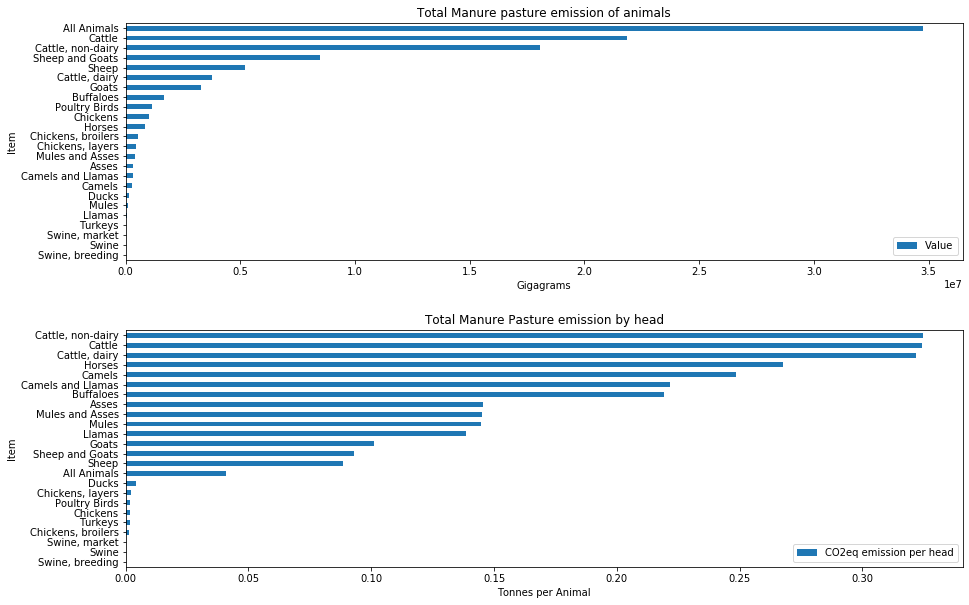

In [26]:
#Grouping stocks count
df_manure_pasture_stocks_grouped = (
    dfs_manure_pasture_filtered["stocks"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_manure_pasture_emission_grouped = (
    dfs_manure_pasture_filtered["emissions"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_pasture_merged = df_manure_pasture_emission_grouped.merge(
    df_manure_pasture_stocks_grouped,
    on="Item",
    suffixes=("_emissions", "_stocks")
)

# Convert to tonnes per animals
df_pasture_merged["CO2eq emission per head"] = df_pasture_merged["Value_emissions"] / df_pasture_merged["Value_stocks"] * 1000

fig, axes = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)

df_manure_pasture_emission_grouped.sort_values("Value").plot.barh(
    "Item",
    title="Total Manure pasture emission of animals",
    ax=axes[0]
)
axes[0].set_xlabel("Gigagrams")
axes[0].legend(loc="lower right")

df_pasture_merged.sort_values("CO2eq emission per head").plot.barh(
    x="Item",
    y="CO2eq emission per head",
    title="Total Manure Pasture emission by head",
    ax=axes[1]
)
axes[1].set_xlabel("Tonnes per Animal")
axes[1].legend(loc="lower right")

### Manure Management
The table ‘Manure_management’ contains the following data:

GHG emissions from manure management consisting of methane and nitrous oxide gases from aerobic and anaerobic manure decomposition processes

In [27]:
df_manure_management.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,Head,1300000.0,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,Head,851850.0,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,Head,1001112.0,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,Head,1300000.0,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,Head,1200000.0,Official data


#### Checking for null values 

In [28]:
print(df_manure_management.isna().any())
print("Array of years will null values :", df_manure_management[df_manure_management["Value"].isna()]["Year"].unique())

#Removing null values(only in predictions)
df_manure_management = df_manure_management[df_manure_management["Year"] < 2030]

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year            False
Unit            False
Value            True
Flag            False
dtype: bool
Array of years will null values : [2030 2050]


#### Element Column

In [29]:
df_manure_management["Element"].unique()

array(['Stocks', 'Manure (N content) (Manure management)',
       'Implied emission factor for CH4 (Manure management)',
       'Implied emission factor for N2O (Manure management)',
       'Emissions (CH4) (Manure management)',
       'Emissions (CO2eq) from CH4 (Manure management)',
       'Direct emissions (N2O) (Manure management)',
       'Indirect emissions (N2O) (Manure management)',
       'Emissions (N2O) (Manure management)',
       'Direct emissions (CO2eq) (Manure management)',
       'Indirect emissions (CO2eq) (Manure management)',
       'Emissions (CO2eq) from N2O (Manure management)',
       'Emissions (CO2eq) (Manure management)'], dtype=object)

Similarly, in the *Element* column we will only be interested in the value of *Stocks* and the value of *Emissions (CO2eq) (Manure management)* which corresponds to the total aggregate of the GHG emission in CO2eq

In [30]:
#Filter the Element Column
dfs_manure_management = split_on(
    df_manure_management[
        df_manure_management["Element"].isin(["Emissions (CO2eq) (Manure management)", "Stocks"])
    ],
    column="Element",
    rename={
        "Stocks": "stocks",
        "Emissions (CO2eq) (Manure management)": "emissions"
    }
)

print("Stock unit :", dfs_manure_management.stocks["Unit"].unique())
print("Emission unit :", dfs_manure_management.emissions["Unit"].unique())

Stock unit : ['Head']
Emission unit : ['Gigagrams']


#### Item column

We keep only data aggregated on the whole world.

In [31]:
print(df_manure_management["Item"].unique())

Animals = df_manure_management["Item"].unique()

column_filters = {
    "Country" : ["World"],
    "Item" : Animals
}

dfs_manure_management_filtered = DotMap(_dynamic=False)
dfs_manure_management_filtered["stocks"] = select_on(
    dfs_manure_management["stocks"],
    column_filter_dict=column_filters
)
dfs_manure_management_filtered["emissions"] = select_on(
    dfs_manure_management["emissions"],
    column_filter_dict=column_filters
)

['Asses' 'Camels' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes' 'Ducks'
 'Turkeys' 'Cattle, dairy' 'Cattle, non-dairy' 'Chickens, broilers'
 'Chickens, layers' 'Swine, breeding' 'Swine, market' 'Llamas'
 'All Animals' 'Camels and Llamas' 'Cattle' 'Chickens' 'Mules and Asses'
 'Poultry Birds' 'Sheep and Goats' 'Swine']


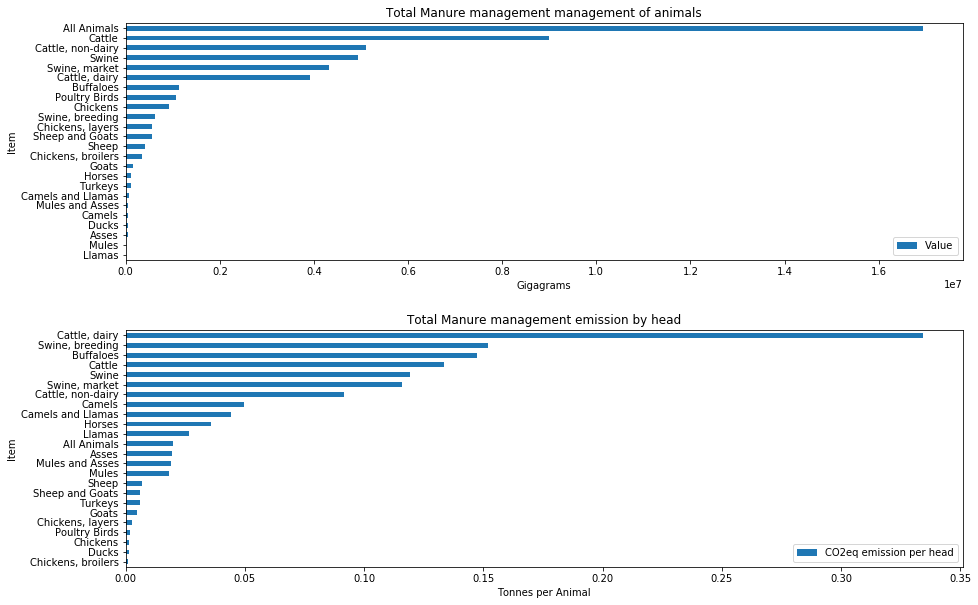

In [32]:
#Grouping stocks count
df_manure_management_stocks_grouped = (
    dfs_manure_management_filtered["stocks"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_manure_management_emission_grouped = (
    dfs_manure_management_filtered["emissions"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_management_merged = df_manure_management_emission_grouped.merge(
    df_manure_pasture_stocks_grouped,
    on="Item",
    suffixes=("_emissions", "_stocks")
)

# Convert to tonnes per animals
df_management_merged["CO2eq emission per head"] = df_management_merged["Value_emissions"] / df_management_merged["Value_stocks"] * 1000

fig, axes = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)

df_manure_management_emission_grouped.sort_values("Value").plot.barh(
    "Item",
    title="Total Manure management management of animals",
    ax=axes[0]
)
axes[0].set_xlabel("Gigagrams")
axes[0].legend(loc="lower right")

df_management_merged.sort_values("CO2eq emission per head").plot.barh(
    x="Item",
    y="CO2eq emission per head",
    title="Total Manure management emission by head",
    ax=axes[1]
)
axes[1].set_xlabel("Tonnes per Animal")
axes[1].legend(loc="lower right")


This tables contain information on animals with defferent level of aggregation. We found in FAO documentation definitions for aggregated animal categories:

- All Animals = Asses	+ Buffaloes + Camels + Cattle, dairy + Cattle, non-dairy + Chickens, broilers + Chickens, layers + Ducks + Goats + Horses + Llamas + Mules + Sheep + Swine, breeding + Swine, market + Turkeys
- Camels and Llamas	=	Camels	+ Llamas
- Cattle = Cattle, dairy +	Cattle, non-dairy
- Chickens	= Chickens, broilers + Chickens, layers	
- Mules and Asses =	Asses + Mules	
- Poultry Birds	= Chickens, broilers	+ Chickens, layers	+ Ducks	+ Turkeys	
- Sheep and Goats =	Goats + Sheep	
- Swine	= Swine, breeding + Swine, market

Because of this mix of raw animals and aggregated categories, we have redundancy in the data.
We want to keep only non overlapping categories. To be compatible with the data we have in the other datasets (production and trade datasets) they must be aggregated to the appropriate level.

Therefore, we keep **'Cattle, dairy', 'Cattle, non-dairy', 'Swine', 'Poultry Birds'**, which are among the categories having the most impact in terms of GHG emissions. We will show how we map these living animals categories to their corresponding products.

In [33]:
Animals = ['Cattle, dairy', 'Cattle, non-dairy', 'Swine', 'Poultry Birds']

In [34]:
#Filtering all tables to keep only the selected animals
dfs_stock = DotMap(
    {
        "enteric_fermentation": dfs_enteric_fermentation.stocks,
        "manure_management": dfs_manure_management.stocks,
        "manure_pasture": dfs_manure_pasture.stocks,
        "manure_soils": dfs_manure_soils.stocks
    },
    _dynamic=False
)

dfs_emissions = DotMap(
    {
        "enteric_fermentation": dfs_enteric_fermentation.emissions,
        "manure_management": dfs_manure_management.emissions,
        "manure_pasture": dfs_manure_pasture.emissions,
        "manure_soils": dfs_manure_soils.emissions
    },
    _dynamic=False
)

column_filters = {"Item": Animals}
for name, df in dfs_stock.items():
    dfs_stock[name] = select_on(df, column_filter_dict=column_filters)
for name, df in dfs_emissions.items():
    dfs_emissions[name] = select_on(df, column_filter_dict=column_filters)

To focus on a good range of years for our analysis we compute for each year the number of countries where there is available data of livestocks.

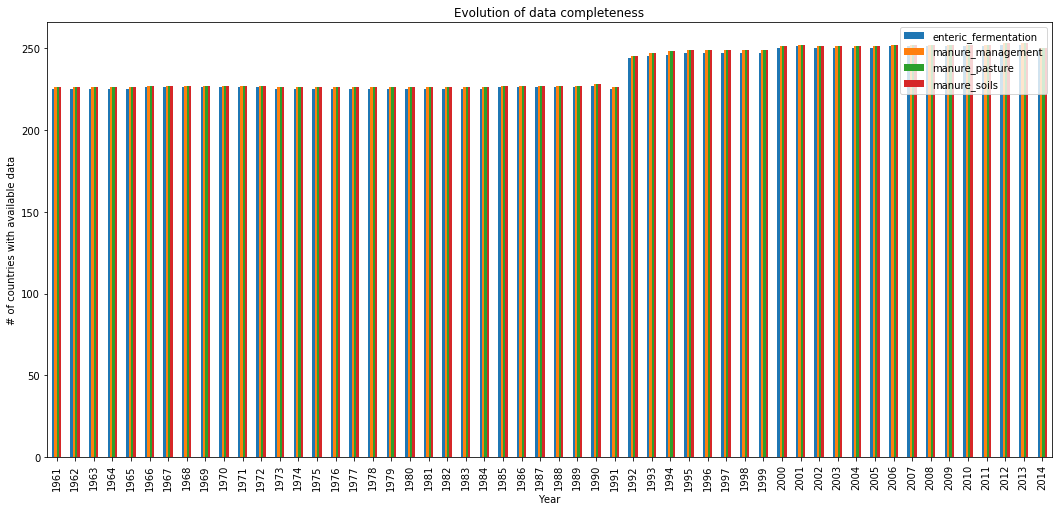

In [35]:
plot_completeness_histogram(dfs_stock, figsize=(18, 8), agg_on="Country Code")

The above histogram showing how complete the data are (number of country with data as a function of time) shows that the data are quite complete. Somme countries seems to have been added in 1992, let's find those.

In [36]:
df = dfs_stock.enteric_fermentation
df_before = df[ df["Year"] == 1991]
df_after = df[ df["Year"] == 1992]

set(df_after["Country"].unique()) - set(df_before["Country"].unique())

{'Armenia',
 'Azerbaijan',
 'Belarus',
 'Bosnia and Herzegovina',
 'Central Asia',
 'Croatia',
 'Estonia',
 'Georgia',
 'Kazakhstan',
 'Kyrgyzstan',
 'Latvia',
 'Lithuania',
 'Republic of Moldova',
 'Russian Federation',
 'Serbia and Montenegro',
 'Slovenia',
 'Tajikistan',
 'The former Yugoslav Republic of Macedonia',
 'Turkmenistan',
 'Ukraine',
 'Uzbekistan'}

This is due to the dilution of the URSS. This will require care in the visualization: the choice of countries to use will most likely be done on a per year basis.

## Computed emissions data

In [37]:
# load base info, drop redundant year code column
df_env_emission_intensity = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Environment_Emissions_intensities_E_All_Data_(Normalized).csv",
    df_flags
).drop("Year Code", axis="columns")

#Remove aggreagated data
df_env_emission_intensity = remove_country_group(df_env_emission_intensity, df_area_groups)

# Split on the Element column
dfs_env_em_intensity = split_on(
    df_env_emission_intensity, "Element",
    drop="Element Code",
    rename=to_snakecase
)
del df_env_emission_intensity
    
for table_name, df in dfs_env_em_intensity.items():
    print(f"\n\nTable {table_name}")
    print(f"  - Units: {', '.join(df['Unit'].unique())}")
    if table_name == "emissions_intensity":
        print("  - Available products:", end="\n      ")
        for k, prod in enumerate(df['Item'].unique()):
            print("%-25s" % prod, end="\n      " if k % 4 == 3 else "")
        print()
    print("  - Sample of 10 values:")
    display(df.sample(10))



Table emissions_intensity
  - Units: kg CO2eq/kg product
  - Available products:
      Cereals excluding rice   Rice, paddy              Meat, cattle             Milk, whole fresh cow    
      Meat, goat               Milk, whole fresh goat   Meat, sheep              Milk, whole fresh sheep  
      Milk, whole fresh camel  Meat, chicken            Eggs, hen, in shell      Milk, whole fresh buffalo
      Meat, pig                Meat, buffalo            
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Year,Unit,Value,Flag
128272,147,Namibia,867,"Meat, cattle",1972,kg CO2eq/kg product,83.5208,Calculated data
159785,189,Saint Lucia,1058,"Meat, chicken",1964,kg CO2eq/kg product,0.4018,Calculated data
135812,158,Niger,27,"Rice, paddy",1969,kg CO2eq/kg product,0.9550,Calculated data
138571,160,Niue,1058,"Meat, chicken",1979,kg CO2eq/kg product,2.2158,Calculated data
184334,176,Timor-Leste,977,"Meat, sheep",2005,kg CO2eq/kg product,133.5387,Calculated data
155372,182,Réunion,1035,"Meat, pig",1998,kg CO2eq/kg product,2.0095,Calculated data
171139,201,Somalia,1058,"Meat, chicken",2008,kg CO2eq/kg product,3.5750,Calculated data
189829,223,Turkey,1017,"Meat, goat",1981,kg CO2eq/kg product,34.7166,Calculated data
189594,223,Turkey,867,"Meat, cattle",1962,kg CO2eq/kg product,96.6060,Calculated data
204825,249,Yemen,977,"Meat, sheep",1979,kg CO2eq/kg product,28.4341,Calculated data




Table emissions_(co2eq)
  - Units: gigagrams
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Year,Unit,Value,Flag
96289,106,Italy,1017,"Meat, goat",1971,gigagrams,52.8309,Calculated data
192144,226,Uganda,977,"Meat, sheep",1977,gigagrams,219.7824,Calculated data
51305,50,Cyprus,1035,"Meat, pig",2000,gigagrams,122.7039,Calculated data
78114,87,Guadeloupe,1058,"Meat, chicken",1986,gigagrams,0.7939,Calculated data
102658,118,Kuwait,1718,Cereals excluding rice,1999,gigagrams,1.2448,Calculated data
176357,207,Suriname,1718,Cereals excluding rice,1982,gigagrams,18.6584,Calculated data
88393,100,India,27,"Rice, paddy",1971,gigagrams,93395.6948,Calculated data
109624,124,Libya,982,"Milk, whole fresh sheep",1992,gigagrams,193.9427,Calculated data
68753,69,French Guiana,867,"Meat, cattle",2005,gigagrams,20.3340,Calculated data
54908,54,Denmark,977,"Meat, sheep",2002,gigagrams,36.9911,Calculated data




Table production
  - Units: tonnes
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Year,Unit,Value,Flag
349036,35,Cabo Verde,882,"Milk, whole fresh cow",2014,tonnes,3636.0,FAO data based on imputation methodology
132303,151,Netherlands Antilles (former),1017,"Meat, goat",1969,tonnes,106.0,Calculated data
356046,151,Netherlands Antilles (former),1035,"Meat, pig",2007,tonnes,195.0,FAO data based on imputation methodology
28320,233,Burkina Faso,1020,"Milk, whole fresh goat",1983,tonnes,9140.0,Calculated data
308062,112,Jordan,1062,"Eggs, hen, in shell",2008,tonnes,50602.0,Official data
350562,72,Djibouti,882,"Milk, whole fresh cow",2002,tonnes,8036.0,FAO data based on imputation methodology
359530,219,Tonga,1035,"Meat, pig",2002,tonnes,1496.0,FAO data based on imputation methodology
238740,142,Montserrat,1718,Cereals excluding rice,1989,tonnes,25.0,"Aggregate, may include official, semi-official..."
343317,59,Egypt,1035,"Meat, pig",1982,tonnes,2600.0,Unofficial figure
325224,225,United Arab Emirates,982,"Milk, whole fresh sheep",1994,tonnes,6609.0,Official data


[]

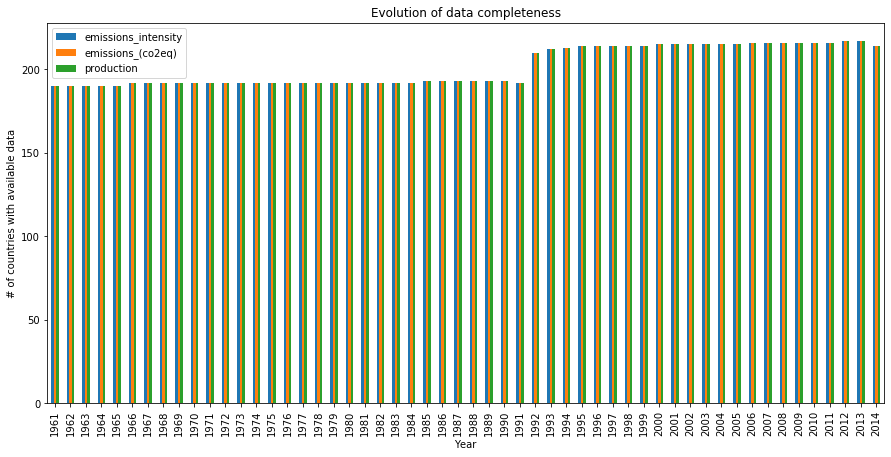

In [38]:
plot_completeness_histogram(dfs_env_em_intensity, figsize=(15, 7))
plt.plot()

The above histogram showing how complete the data are (number of country with data as a function of time) shows that the data are quite complete. Somme countries seems to have been added in 1992, let's find those.

In [39]:
df = dfs_env_em_intensity.production
df_before = df[ df["Year"] == 1991]
df_after = df[ df["Year"] == 1992]

set(df_after["Area"].unique()) - set(df_before["Area"].unique())

{'Armenia',
 'Azerbaijan',
 'Belarus',
 'Bosnia and Herzegovina',
 'Croatia',
 'Estonia',
 'Georgia',
 'Kazakhstan',
 'Kyrgyzstan',
 'Latvia',
 'Lithuania',
 'Republic of Moldova',
 'Russian Federation',
 'Serbia and Montenegro',
 'Slovenia',
 'Tajikistan',
 'The former Yugoslav Republic of Macedonia',
 'Turkmenistan',
 'Ukraine',
 'Uzbekistan'}

This is due to the dilution of the URSS. This will require special handling in the analysis and visualization: the choice of countries to use will most likely be done on a per year basis.

## Productions

In [40]:
# Load, remove duplicate column "year code"
df_prod_animals = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Production_LivestockPrimary_E_All_Data_(Normalized).csv",
    df_flags
).drop(columns="Year Code")


#remove aggregated data
df_prod_animals = remove_country_group(df_prod_animals, df_area_groups)

# Harmonise units
## 1000 Head -> Head
unit_filter = df_prod_animals["Unit"] == "1000 Head"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].multiply(1000)
df_prod_animals.loc[unit_filter, "Unit"] = "Head"

## 1000 No -> No
unit_filter = df_prod_animals["Unit"] == "1000 No"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].multiply(1000)
df_prod_animals.loc[unit_filter, "Unit"] = "No"

## 100mg/An 0.1g/An -> g/An
unit_filter = df_prod_animals["Unit"].isin(["100mg/An", "0.1g/An"])
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(10)
df_prod_animals.loc[unit_filter, "Unit"] = "g/An"

## hg/An -> kg/An
unit_filter = df_prod_animals["Unit"] == "hg/An"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(10)
df_prod_animals.loc[unit_filter, "Unit"] = "kg/An"

## hg -> kg
unit_filter = df_prod_animals["Unit"] == "hg"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(10)
df_prod_animals.loc[unit_filter, "Unit"] = "kg"

# Split according to Element column
dfs_prod_animals = split_on(
    df_prod_animals,
    "Element",
    rename=to_snakecase
)


for table_name, df in dfs_prod_animals.items():
    print(f"\n\nTable {table_name}")
    print(f"  - Units: {', '.join(df['Unit'].unique())}")
    #if table_name == "production":
    print("  - Available products:", end="\n      ")
    for k, prod in enumerate(df['Item'].unique()):
        print("%-36s" % prod.strip(), end="\n      " if k % 3 == 2 else "")
    print()
    print("  - Sample of 10 values:")
    display(df.sample(10))



Table laying
  - Units: Head
  - Available products:
      Eggs, hen, in shell                 Eggs, other bird, in shell          Eggs, hen, in shell (number)        
      Eggs Primary                        
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
737366,90,Guinea,1062,"Eggs, hen, in shell",5313,2013,Head,7080000.0,FAO data based on imputation methodology
750940,160,Niue,1062,"Eggs, hen, in shell",5313,2013,Head,4000.0,FAO data based on imputation methodology
878842,156,New Zealand,1783,Eggs Primary,5313,2013,Head,3424000.0,"Aggregate, may include official, semi-official..."
883964,221,Oman,1783,Eggs Primary,5313,1972,Head,60000.0,"Aggregate, may include official, semi-official..."
108506,117,Republic of Korea,1091,"Eggs, other bird, in shell",5313,1967,Head,95000.0,FAO estimate
119032,197,Sierra Leone,1091,"Eggs, other bird, in shell",5313,1976,Head,6000.0,FAO estimate
795603,18,Bhutan,1783,Eggs Primary,5313,1963,Head,55000.0,"Aggregate, may include official, semi-official..."
90421,144,Mozambique,1062,"Eggs, hen, in shell",5313,1981,Head,390000.0,FAO estimate
848023,99,Iceland,1783,Eggs Primary,5313,2014,Head,219000.0,"Aggregate, may include official, semi-official..."
874612,147,Namibia,1783,Eggs Primary,5313,1972,Head,188000.0,"Aggregate, may include official, semi-official..."




Table production
  - Units: tonnes, No, Head
  - Available products:
      Eggs, hen, in shell                 Eggs, hen, in shell (number)        Honey, natural                      
      Meat indigenous, camel              Meat indigenous, cattle             Meat indigenous, chicken            
      Meat indigenous, goat               Meat indigenous, sheep              Meat, cattle                        
      Meat, game                          Meat, goat                          Meat, sheep                         
      Milk, whole fresh cow               Milk, whole fresh goat              Milk, whole fresh sheep             
      Silk-worm cocoons, reelable         Wool, greasy                        Eggs, other bird, in shell          
      Eggs, other bird, in shell (number) Meat indigenous, pig                Meat, chicken                       
      Meat, nes                           Meat, pig                           Milk, whole fresh buffalo           
      Mea

,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
211628,143,Morocco,977,"Meat, sheep",5510,1984,tonnes,49970.0,Official data
849044,100,India,1808,"Meat, Poultry",5510,1961,tonnes,77839.0,"Aggregate, may include official, semi-official..."
152114,11,Austria,1182,"Honey, natural",5510,2013,tonnes,5000.0,Official data
241747,210,Sweden,1097,"Meat, horse",5510,1966,tonnes,7755.0,Official data
711953,149,Nepal,1091,"Eggs, other bird, in shell",5510,1997,tonnes,1120.0,Unofficial figure
710783,134,Malta,1017,"Meat, goat",5510,1995,tonnes,16.0,Unofficial figure
591880,219,Tonga,1058,"Meat, chicken",5510,1986,tonnes,261.0,Calculated data
110581,183,Romania,1055,"Meat indigenous, pig",5322,1982,Head,10000000.0,FAO estimate
118194,196,Seychelles,1067,"Eggs, hen, in shell (number)",5513,2002,No,40000000.0,FAO estimate
786392,9,Argentina,1806,Beef and Buffalo Meat,5510,1992,tonnes,2784000.0,"Aggregate, may include official, semi-official..."




Table producing_animals/slaughtered
  - Units: Head
  - Available products:
      Hides, cattle, fresh                Meat, camel                         Meat, cattle                        
      Meat, chicken                       Meat, goat                          Meat, sheep                         
      Skins, goat, fresh                  Skins, sheep, fresh                 Meat, pig                           
      Meat, horse                         Meat, rabbit                        Meat, turkey                        
      Meat, duck                          Meat, goose and guinea fowl         Skins, sheep, with wool             
      Hides, buffalo, fresh               Meat, buffalo                       Meat, other camelids                
      Meat, other rodents                 Meat, ass                           Meat, mule                          
      Meat, bird nes                      Meat, game                          Meat, nes                           
  

,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
58239,89,Guatemala,995,"Skins, sheep, fresh",5320,1980,Head,141000.0,FAO estimate
769007,27,Bulgaria,1089,"Meat, bird nes",5321,2005,Head,NaN,Data not available
857661,118,Kuwait,1806,Beef and Buffalo Meat,5320,1976,Head,6207.0,"Aggregate, may include official, semi-official..."
70389,106,Italy,1080,"Meat, turkey",5321,1969,Head,5000000.0,FAO estimate
117884,195,Senegal,995,"Skins, sheep, fresh",5320,1966,Head,571000.0,FAO estimate
454161,256,Luxembourg,977,"Meat, sheep",5320,2005,Head,3698.0,Calculated data
171867,50,Cyprus,1035,"Meat, pig",5320,1989,Head,390000.0,Official data
27231,39,Chad,1025,"Skins, goat, fresh",5320,1980,Head,700000.0,FAO estimate
56774,87,Guadeloupe,1025,"Skins, goat, fresh",5320,1990,Head,24400.0,FAO estimate
762996,223,Turkey,1097,"Meat, horse",5320,1999,Head,14300.0,FAO data based on imputation methodology




Table milk_animals
  - Units: Head
  - Available products:
      Milk, whole fresh camel             Milk, whole fresh cow               Milk, whole fresh goat              
      Milk, whole fresh sheep             Milk, whole fresh buffalo           Milk,Total                          
      
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
743628,124,Libya,982,"Milk, whole fresh sheep",5318,2005,Head,1679159.0,FAO data based on imputation methodology
853673,106,Italy,1780,"Milk,Total",5318,1964,Head,10274200.0,"Aggregate, may include official, semi-official..."
136699,226,Uganda,882,"Milk, whole fresh cow",5318,2003,Head,2687000.0,FAO estimate
857001,114,Kenya,1780,"Milk,Total",5318,1961,Head,3316000.0,"Aggregate, may include official, semi-official..."
217814,159,Nigeria,882,"Milk, whole fresh cow",5318,1961,Head,602800.0,Official data
217830,159,Nigeria,882,"Milk, whole fresh cow",5318,1977,Head,1122300.0,Official data
55618,86,Grenada,882,"Milk, whole fresh cow",5318,1995,Head,650.0,FAO estimate
849905,101,Indonesia,1780,"Milk,Total",5318,1961,Head,4590000.0,"Aggregate, may include official, semi-official..."
65709,101,Indonesia,1020,"Milk, whole fresh goat",5318,2005,Head,5364000.0,FAO estimate
86793,137,Mauritius,882,"Milk, whole fresh cow",5318,2011,Head,4500.0,FAO estimate




Table prod_popultn
  - Units: Head, No
  - Available products:
      Wool, greasy                        Honey, natural                      Beeswax                             
      Silk-worm cocoons, reelable         Hair, horse                         
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
781208,226,Uganda,1182,"Honey, natural",5314,1975,No,NaN,Data not available
94536,149,Nepal,987,"Wool, greasy",5319,1963,Head,560000.0,FAO estimate
768118,255,Belgium,1182,"Honey, natural",5314,2013,No,NaN,Data not available
64151,100,India,1183,Beeswax,5314,1962,No,5000000.0,FAO estimate
752446,169,Paraguay,1182,"Honey, natural",5314,2004,No,62580.0,FAO data based on imputation methodology
166912,214,"China, Taiwan Province of",1182,"Honey, natural",5314,2003,No,0.0,Official data
769234,27,Bulgaria,1185,"Silk-worm cocoons, reelable",5319,1999,Head,NaN,Data not available
776737,160,Niue,1183,Beeswax,5314,2010,No,NaN,Data not available
773438,85,Greenland,1182,"Honey, natural",5314,2004,No,NaN,Data not available
781625,236,Venezuela (Bolivarian Republic of),1182,"Honey, natural",5314,1968,No,NaN,Data not available




Table yield
  - Units: g/An, kg/An, kg
  - Available products:
      Eggs, hen, in shell                 Hides, cattle, fresh                Milk, whole fresh camel             
      Milk, whole fresh cow               Milk, whole fresh goat              Milk, whole fresh sheep             
      Skins, goat, fresh                  Skins, sheep, fresh                 Wool, greasy                        
      Eggs Primary                        Milk,Total                          Milk, whole fresh buffalo           
      Skins, sheep, with wool             Eggs, other bird, in shell          Hides, buffalo, fresh               
      Honey, natural                      Beeswax                             
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
458587,131,Malaysia,1062,"Eggs, hen, in shell",5410,1992,g/An,7500.0,Calculated data
261483,3,Albania,1783,Eggs Primary,5410,2004,g/An,7973.0,Calculated data
336158,44,Colombia,1780,"Milk,Total",5420,1991,kg/An,965.6,Calculated data
592283,219,Tonga,1783,Eggs Primary,5410,1980,g/An,4000.0,Calculated data
286115,15,Belgium-Luxembourg,1780,"Milk,Total",5420,1993,kg/An,4798.9,Calculated data
337213,45,Comoros,882,"Milk, whole fresh cow",5420,1993,kg/An,500.0,Calculated data
508978,221,Oman,1780,"Milk,Total",5420,2011,kg/An,125.3,Calculated data
424404,104,Ireland,919,"Hides, cattle, fresh",5420,1991,kg/An,39.8,Calculated data
529756,117,Republic of Korea,1091,"Eggs, other bird, in shell",5410,2009,g/An,9264.7,Calculated data
593610,220,Trinidad and Tobago,995,"Skins, sheep, fresh",5420,1968,kg/An,3.0,Calculated data




Table yield/carcass_weight
  - Units: kg/An, g/An
  - Available products:
      Meat indigenous, camel              Meat indigenous, cattle             Meat indigenous, chicken            
      Meat indigenous, goat               Meat indigenous, sheep              Meat, camel                         
      Meat, cattle                        Meat, chicken                       Meat, goat                          
      Meat, sheep                         Beef and Buffalo Meat               Meat, Poultry                       
      Sheep and Goat Meat                 Meat indigenous, pig                Meat, pig                           
      Meat indigenous, horse              Meat indigenous, rabbit             Meat indigenous, turkey             
      Meat, horse                         Meat, rabbit                        Meat, turkey                        
      Meat indigenous, duck               Meat indigenous, geese              Meat, duck                          
    

,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
601395,226,Uganda,1035,"Meat, pig",5417,2011,kg/An,60.0,Calculated data
278552,12,Bahamas,1807,Sheep and Goat Meat,5417,2008,kg/An,12.5,Calculated data
326712,96,"China, Hong Kong SAR",1017,"Meat, goat",5417,1998,kg/An,12.5,Calculated data
450444,123,Liberia,1035,"Meat, pig",5417,1977,kg/An,40.0,Calculated data
476496,141,Mongolia,1806,Beef and Buffalo Meat,5417,1970,kg/An,136.8,Calculated data
414656,100,India,972,"Meat indigenous, buffalo",5417,1965,kg/An,138.0,Calculated data
393582,84,Greece,1017,"Meat, goat",5417,2003,kg/An,11.2,Calculated data
411714,97,Hungary,1087,"Meat indigenous, turkey",5424,1968,g/An,3500.0,Calculated data
331425,41,"China, mainland",1111,"Meat, mule",5417,2013,kg/An,100.0,Calculated data
492739,151,Netherlands Antilles (former),1012,"Meat indigenous, sheep",5417,1979,kg/An,10.0,Calculated data


In [41]:
df_pr = dfs_prod_animals.production
df_y = dfs_prod_animals["yield"]

s = set(df_pr["Item Code"].unique()) -  set(df_y["Item Code"].unique())

df_pr[ df_pr['Item Code'].isin(s)]["Item"].unique()

array(['Eggs, hen, in shell (number)', 'Meat indigenous, camel',
       'Meat indigenous, cattle', 'Meat indigenous, chicken',
       'Meat indigenous, goat', 'Meat indigenous, sheep', 'Meat, cattle',
       'Meat, game', 'Meat, goat', 'Meat, sheep',
       'Silk-worm cocoons, reelable',
       'Eggs, other bird, in shell (number)', 'Meat indigenous, pig',
       'Meat, chicken', 'Meat, nes', 'Meat, pig',
       'Meat indigenous, horse', 'Meat indigenous, rabbit',
       'Meat indigenous, turkey', 'Meat, camel', 'Meat, horse',
       'Meat indigenous, duck', 'Meat indigenous, geese', 'Meat, duck',
       'Meat, turkey', 'Meat, goose and guinea fowl', 'Meat, rabbit',
       'Meat indigenous, buffalo', 'Meat, buffalo',
       'Meat indigenous, other camelids', 'Meat indigenous, rodents',
       'Meat, other camelids', 'Meat indigenous, ass',
       'Meat indigenous, bird nes', 'Meat indigenous, mule', 'Meat, ass',
       'Meat, mule', 'Snails, not sea', 'Meat, bird nes', 'Hair, horse',
 

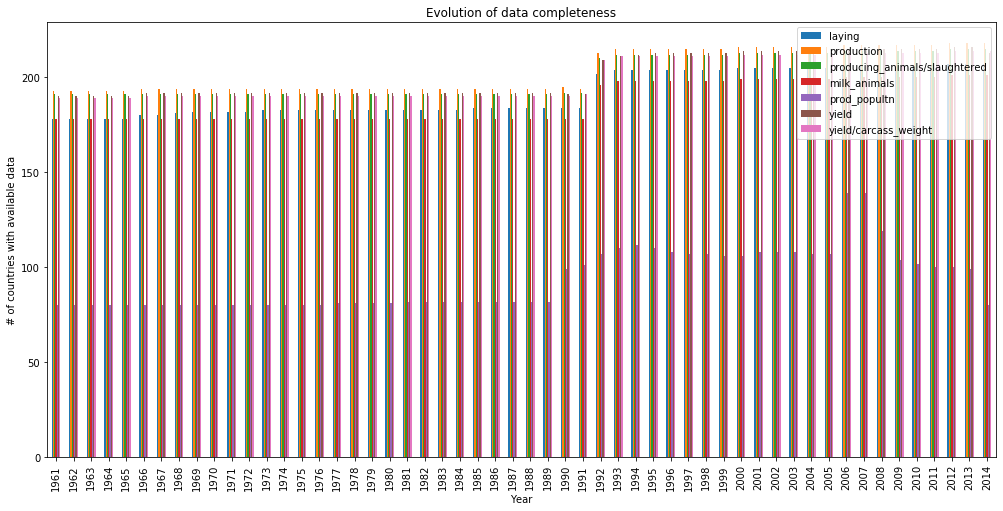

In [42]:
plot_completeness_histogram(dfs_prod_animals, figsize=(17,8))

The above bar plot shows that the `prod_popultn` Table has a lot of missing countries. Given the data it holds, namely the production of `['Wool, greasy', 'Honey, natural', 'Beeswax', 'Silk-worm cocoons, reelable', 'Hair, horse']`, this is not a problem.

The tables we are mostly interested in are `production`, `yield` and `producing_animals/slaughtered`, so we will have to consider only contries at least in those three tables.

## Trade data

In [43]:
raw_trade_matrix = pd.read_csv("data/detailed_trade_matrix/Trade_DetailedTradeMatrix_E_All_Data_NOFLAG.csv", encoding="Latin1")
raw_trade_matrix.sample(5)

,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Element Code,Element,Unit,Y1986,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
591496,21,Brazil,16,Bangladesh,56,Maize,5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28854.0,118715.0,158604.0
4597458,216,Thailand,162,Norway,666,Chocolate products nes,5610,Import Quantity,tonnes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,1.0
1051949,44,Colombia,21,Brazil,474,"Vegetables, temporarily preserved",5610,Import Quantity,tonnes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2134889,100,India,15,Belgium-Luxembourg,1009,"Wool, hair waste",5910,Export Quantity,tonnes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
780105,33,Canada,66,Fiji,515,Apples,5910,Export Quantity,tonnes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
raw_trade_matrix["Element"].unique()

array(['Export Quantity', 'Export Value', 'Import Quantity',
       'Import Value'], dtype=object)

Detailed trade matrix contains trade information in terms of **quantity** and in terms of **value**. According to FAO documentation, information in terms of value is sometime inconsistent because some countries report values including insurance/transport costs and others report values excluding these costs. Therefore, we will use only **quantity** information.

In [45]:
dfs_trade = split_on(raw_trade_matrix, 
                     "Element", 
                     rename={"Export Quantity":"export","Import Quantity":"import"}, 
                     only_named=True, 
                     drop=["Element Code","Element"])

In [46]:
del raw_trade_matrix

dfs_trade contains two dataframes:
- dfs_trade.export contains trade information reported by exporter country
- dfs_trade.import contains trade information reported by importer country

There is redundancy in this information because a transaction is normally reported both by importer and exporter country.

We want to remove this redundancy, without sacrificing information.

Let us have a look at the amount of information available for each year.

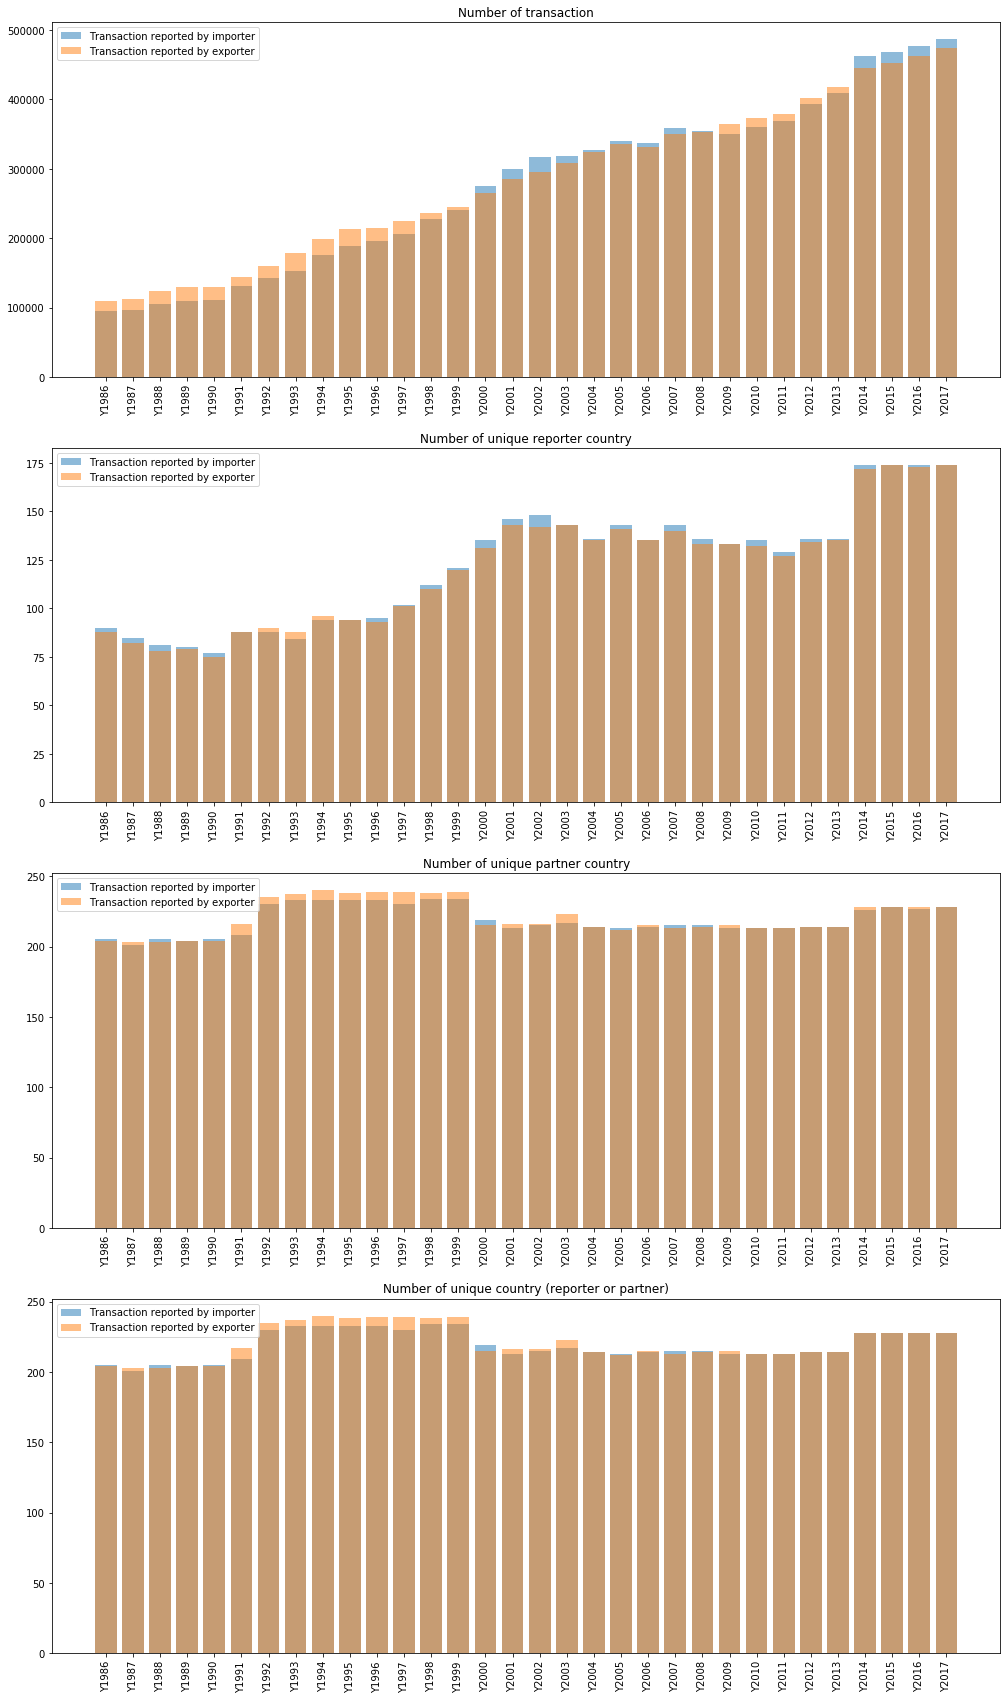

In [47]:
years = ['Y1986', 'Y1987', 'Y1988', 'Y1989', 'Y1990', 'Y1991', 'Y1992', 'Y1993', 'Y1994', 'Y1995', 'Y1996', 'Y1997',
         'Y1998', 'Y1999', 'Y2000', 'Y2001', 'Y2002', 'Y2003', 'Y2004', 'Y2005', 'Y2006', 'Y2007', 'Y2008', 'Y2009',
         'Y2010', 'Y2011', 'Y2012', 'Y2013', 'Y2014', 'Y2015', 'Y2016', 'Y2017']

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(17,30))

for direction in ["import","export"]:
    n_rows = []
    n_reporter = []
    n_partner = []
    n_countries = []

    for year in years :
        n_rows.append(len(dfs_trade[direction][dfs_trade[direction][year].notna()]))
        reporters = dfs_trade[direction][dfs_trade[direction][year].notna()]["Reporter Countries"].unique()
        partners = dfs_trade[direction][dfs_trade[direction][year].notna()]["Partner Countries"].unique()
        n_reporter.append(len(reporters))
        n_partner.append(len(partners))
        n_countries.append(len(np.unique(np.concatenate((reporters,partners)))))
        
    axs[0].bar(years, n_rows, alpha=0.5)
    axs[0].set_title("Number of transaction")
    axs[1].bar(years, n_reporter, alpha=0.5)
    axs[1].set_title("Number of unique reporter country")
    axs[2].bar(years, n_partner, alpha=0.5)
    axs[2].set_title("Number of unique partner country")
    axs[3].bar(years, n_countries, alpha=0.5)
    axs[3].set_title("Number of unique country (reporter or partner)")

for ax in axs:
    ax.set_xticklabels(labels=years,rotation=90)
    ax.legend(["Transaction reported by importer","Transaction reported by exporter"])
plt.show()

We notice that the number of reporting countries is significatively inferior to the total number of countries involved in trade, especially for the first years of the period.

Therefore, we cannot choose to use either dataframe from import or export point of view, because we would loose information.

We have to combine information from both dataframes. This will enable us to get information about coutries that did not report their transactions.

In [48]:
for direction in ["import","export"]:
    print(direction+" dataframe")
    display(dfs_trade[direction].sample(10))

import dataframe


,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Unit,Y1986,Y1987,Y1988,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
825872,33,Canada,210,Sweden,58,"Flour, maize",tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2814525,131,Malaysia,15,Belgium-Luxembourg,168,Sugar confectionery,tonnes,5.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4054454,200,Singapore,96,"China, Hong Kong SAR",1242,"Margarine, short",tonnes,NaN,NaN,1.0,...,3.0,0.0,1.0,0.0,0.0,8.0,0.0,NaN,NaN,0.0
4472301,211,Switzerland,10,Australia,875,"Meat, beef, preparations",tonnes,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN
2523321,112,Jordan,216,Thailand,1166,Meat nes,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2831829,131,Malaysia,101,Indonesia,129,"Starch, cassava",tonnes,NaN,NaN,NaN,...,12709.0,460.0,6984.0,13523.0,100.0,28901.0,22132.0,99.0,113.0,40.0
2496741,110,Japan,223,Turkey,16,"Flour, wheat",tonnes,NaN,NaN,NaN,...,66.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0
2220687,101,Indonesia,100,India,920,"Hides, cattle, wet salted",tonnes,NaN,NaN,NaN,...,0.0,0.0,31.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0
4860850,225,United Arab Emirates,299,Palestine,1293,Crude materials,tonnes,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
971026,41,"China, mainland",131,Malaysia,253,"Cake, copra",tonnes,NaN,NaN,NaN,...,17.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


export dataframe


,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Unit,Y1986,Y1987,Y1988,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
4888783,229,United Kingdom,11,Austria,490,Oranges,tonnes,89.0,NaN,NaN,...,0.0,NaN,NaN,NaN,7.0,3.0,NaN,1.0,NaN,NaN
4367857,38,Sri Lanka,50,Cyprus,626,"Fruit, cooked, homogenized preparations",tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0
5108407,231,United States of America,117,Republic of Korea,1063,"Eggs, liquid",tonnes,37.0,7.0,NaN,...,576.0,569.0,485.0,240.0,1087.0,667.0,899.0,211.0,96.0,6021.0
940493,41,"China, mainland",21,Brazil,845,"Feed, compound nes",tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5199233,249,Yemen,225,United Arab Emirates,997,"Skins, sheep, dry salted",tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10.0,8.0,NaN,NaN
1733637,75,Gambia,15,Belgium-Luxembourg,257,"Oil, palm",tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3129753,150,Netherlands,90,Guinea,1293,Crude materials,tonnes,7.0,0.0,0.0,...,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4230422,202,South Africa,136,Mauritania,237,"Oil, soybean",tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355525,57,Belarus,112,Jordan,1061,"Meat, chicken, canned",tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN
3763125,146,Republic of Moldova,230,Ukraine,1243,"Fat nes, prepared",tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


We first transform both dataframes to get a row for each transaction (we "explode" year columns)

In [49]:
for direction in ["import","export"]:
    dfs_trade[direction] = dfs_trade[direction].melt(id_vars=['Reporter Country Code', 'Reporter Countries', 'Partner Country Code',
           'Partner Countries', 'Item Code', 'Item', 'Unit'],var_name="Year", value_name='Quantity')
    dfs_trade[direction] = dfs_trade[direction][dfs_trade[direction]["Quantity"].notna()]
    print(direction+" dataframe")
    display(dfs_trade[direction].sample(10))

import dataframe


,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Unit,Year,Quantity
27076529,231,United States of America,170,Peru,544,Strawberries,tonnes,Y2005,23.0
34932106,194,Saudi Arabia,21,Brazil,237,"Oil, soybean",tonnes,Y2011,1000.0
17190370,170,Peru,54,Denmark,1293,Crude materials,tonnes,Y1998,0.0
29333954,159,Nigeria,41,"China, mainland",334,"Oil, linseed",tonnes,Y2007,131.0
28555639,13,Bahrain,203,Spain,391,"Tomatoes, paste",tonnes,Y2007,2.0
35477616,37,Central African Republic,100,India,30,Rice - total (Rice milled equivalent),tonnes,Y2012,925.0
3702563,182,Réunion,150,Netherlands,562,"Juice, grape",tonnes,Y1988,64.0
18176473,97,Hungary,210,Sweden,49,Malt,tonnes,Y1999,5.0
37480330,154,North Macedonia,234,Uruguay,999,"Skins, sheep, with wool",tonnes,Y2013,53.0
19421844,68,France,203,Spain,76,Oats rolled,tonnes,Y2000,47.0


export dataframe


,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Unit,Year,Quantity
33107531,27,Bulgaria,154,North Macedonia,1293,Crude materials,tonnes,Y2012,100.0
13429655,150,Netherlands,174,Portugal,290,"Oil, sesame",tonnes,Y1996,0.0
25483648,21,Brazil,68,France,767,Cotton lint,tonnes,Y2006,40.0
40103812,169,Paraguay,56,Dominican Republic,826,"Tobacco, unmanufactured",tonnes,Y2017,421.0
31865400,33,Canada,150,Netherlands,22,Pastry,tonnes,Y2011,33.0
2737795,96,"China, Hong Kong SAR",10,Australia,769,Cotton waste,tonnes,Y1988,1016.0
39521117,214,"China, Taiwan Province of",96,"China, Hong Kong SAR",994,Grease incl. lanolin wool,tonnes,Y2017,0.0
32496120,166,Panama,22,Aruba,491,"Juice, orange, single strength",tonnes,Y2011,54.0
18482844,150,Netherlands,68,France,289,Sesame seed,tonnes,Y2000,1747.0
28655926,156,New Zealand,160,Niue,517,Cider etc,tonnes,Y2008,1.0


We rename columns concerning "reporter" and "partner" as "exporter" and "importer" for both dataframe according to the direction.

In [50]:
dfs_trade["export"].rename(columns={"Reporter Country Code":"Exporter Code",
                                    "Reporter Countries":"Exporter",
                                    "Partner Country Code":"Importer Code",
                                    "Partner Countries":"Importer"},inplace=True)
dfs_trade["import"].rename(columns={"Reporter Country Code":"Importer Code",
                                    "Reporter Countries":"Importer",
                                    "Partner Country Code":"Exporter Code",
                                    "Partner Countries":"Exporter"},inplace=True)

We merge both dataframe.

In [51]:
trade_matrix = (dfs_trade["import"].merge(dfs_trade["export"],
                      on=["Importer Code","Importer","Exporter Code","Exporter","Item Code","Item","Year"],
                      how="outer",
                      suffixes=(' Importer Report', ' Exporter Report'))
                       [["Importer Code","Importer","Exporter Code","Exporter","Item Code","Item","Year","Unit Importer Report","Quantity Importer Report","Unit Exporter Report","Quantity Exporter Report"]])

In [52]:
del dfs_trade

We now have a unique dataframe for trade information, combining all available reports of transaction from importers and exporters.

According to FAO documentations, there may be some discrepancies between reports from importer and exporter about a transaction (for instance in the case of a loss of part of the load during transport). 
We do not have any reason to trust more one of the reporter. We will therefore keep redundant information when available, and try using in priority on or the other of both dataframe for our study, and see if it affects our results.

The following function return unit and quantity for transaction of `item` between `importer` and `exporter` during `year`, giving `priority` to import or export information if both coutries reported this transaction, or available information if this is not the case. 

In [53]:
def get_value(importer, exporter, year, item, priority, merged_trade_matrix):
    """
    priority = {"import", "export"}
    Information taken in priority from either exporter or importer country report
    """
    #more efficient than standard access
    row = merged_trade_matrix.query(
        "(Importer == @importer) & (Exporter == @exporter) & (Year == @year) & (Item == @item)"
    )
    if priority == "import":
        if row["Quantity Importer Report"].isna().any():
            result = (row[["Unit Exporter Report", "Quantity Exporter Report"]])
        else:
            result = (row[["Unit Importer Report", "Quantity Importer Report"]])
    else:
        if row["Quantity Exporter Report"].isna().any():
            result = (row[["Unit Importer Report", "Quantity Importer Report"]])
        else:
            result = (row[["Unit Exporter Report", "Quantity Exporter Report"]])
    if len(result):
        return tuple(result.iloc[0])
    return np.nan, np.nan

# Products Filtering

In the detailed trade matrix, hundreds of different items are present. Most of them are irrelevant for our study focusing on livestock. We want to avoid having to filter them by hand. We will therefore use the item groups that FAO defined ans used to create aggregated version of the trade matrix.


*(NB: We did not directly use aggregated trade datasets from FAO instead of detailed trade matrix because in these datasets information is also aggregated by coutry so information about trading partner is lost.)*


We load item groups definition from FAO for crop and livestock.

In [54]:
print(len(trade_matrix["Item"].unique()))
trade_matrix["Item"].unique()

423


array(['Flour, wheat', 'Beans, dry', 'Maize', 'Oil, rapeseed',
       'Oil, sunflower', 'Oil, vegetable origin nes', 'Butter, cow milk',
       'Cheese, whole cow milk', 'Crude materials', 'Milk, whole dried',
       'Wool, degreased', 'Wool, greasy', 'Cattle', 'Chickens',
       'Food prep nes', 'Glucose and dextrose', 'Jute',
       'Animals live nes', 'Cake, soybeans', 'Eggs, hen, in shell',
       'Fatty acids', 'Grease incl. lanolin wool',
       'Hides, cattle, wet salted', 'Infant food',
       'Milk, whole condensed', 'Oil, citronella', 'Oil, essential nes',
       'Potatoes', 'Rubber, natural', 'Sugar nes', 'Sugar refined',
       'Tobacco, unmanufactured', 'Cocoa, powder & cake', 'Coffee, green',
       'Oil, castor beans', 'Pepper (piper spp.)',
       'Sugar Raw Centrifugal', 'Meat, cattle, boneless (beef & veal)',
       'Meat, sheep', 'Sheep', 'Milk, skimmed dried',
       'Milk, whole evaporated', 'Oilseeds nes', 'Tallow', 'Wheat', 'Tea',
       'Cigars, cheroots', 'Malt

In [55]:
item_groups_product_with_factor = pd.read_csv("data/definitions_and_standards/item_group_crops_and_livestock_products_with_factor.csv", encoding="Latin1", usecols=["Item Group Code","Item Group","Item Code","Item","Factor"])
item_groups_product_with_factor.drop_duplicates(inplace=True)
print(len(item_groups_product_with_factor["Item Group"].unique()))
item_groups_product_with_factor["Item Group"].unique()

11


array(['Bovine Meat', 'Cassava Equivalent', 'Cereals',
       'Groundnuts Total Shelled', 'Milk Equivalent', 'Pigmeat',
       'Poultry Meat', 'Rice', 'Sugar, Total (Raw Equiv.)', 'Total Meat',
       'Wheat+Flour,Wheat Equivalent'], dtype=object)

We now have a small number of item group that we can easily filter by hand. We map the selected item groups to animal categories selected at the end of part 4.2.



In [57]:
filter_dict = {"Cattle, non-dairy": "Bovine Meat", "Cattle, dairy": "Milk Equivalent",
               "Swine": "Pigmeat", "Poultry Birds": "Poultry Meat" }

We filter trade and production datasets, keeping only rows about items belonging to one of the selected groups.

In [58]:
def filter_itemgroups(df,item_groups_product_with_factor,item_groups):
    """
    Filter the DataFrame df to keep only the items from  the list *item_groups*
    according to the dataframe item_groups_product_with_factor along with their factor
    
    Args:
        df: the dataframe to filter
        item_groups_product_with_factor: a DataFrame with mapping of item -> item_group
        item_groups : list of item_groups to keep
    
    Returns:
        The filtered dataframe
    """
    groups = select_on(item_groups_product_with_factor,
                       {"Item Group": item_groups})
    return df.merge(groups, on=['Item','Item Code'])

In item group definition, the column factor corresponds to a coefficient we have to apply to quantity during aggregation in order to get equivalent quantity of item group (for instance, 1.3 kg of dry beef corresponds to 1 kg of bovine meat). This will be usefull to make the link between production and trade datasets and living animal stocks.

In [59]:
item_groups_product_with_factor.head()

,Item Group Code,Item Group,Item Code,Item,Factor
0,2071,Bovine Meat,874,"Meat, beef and veal sausages",1.0
2,2071,Bovine Meat,872,"Meat, beef, dried, salted, smoked",1.3
4,2071,Bovine Meat,875,"Meat, beef, preparations",1.3
6,2071,Bovine Meat,947,"Meat, buffalo",1.0
8,2071,Bovine Meat,867,"Meat, cattle",1.0


In [60]:
item_groups = ["Bovine Meat", "Milk Equivalent","Pigmeat", "Poultry Meat"]

#Filtering production tables
for df in dfs_prod_animals:
    dfs_prod_animals[df] = filter_itemgroups(dfs_prod_animals[df],
                                             item_groups_product_with_factor,
                                             item_groups)
#Filtering detail trade table
trade_matrix = filter_itemgroups(trade_matrix,
                                item_groups_product_with_factor,
                                item_groups)
    
    

# Livestock food estimate

Using [http://www.agronext.iastate.edu/immag/pubs/manure-prod-char-d384-2.pdf](http://www.agronext.iastate.edu/immag/pubs/manure-prod-char-d384-2.pdf), we can try to estimate the food consuption of some livestock

## Beef

Using the above reference, section 4 for the equations, Table 2 for variable definitons, and Tables 3a and 3b for assumption, we get:

$$
\begin{align}
    \mathit{DM} &= \sum_{ration} \left(
                    \mathit{DMI}_\mathit{ration}
                    \times \mathit{DOF}_\mathit{ration}
                    \times \left(1 - \frac{\mathit{DMD}_\mathit{ration}}{100}\right)
                   \right)
                    +
                   \sum_{ration} \left(
                    \mathit{DOF}_\mathit{ration}
                    \times 20.3 \times 0.06
                    \times \mathit{BW}_\mathit{AVG}
                  \right)
\end{align}
$$
where:
+ $\mathit{DM}$: total dry matter excretion
+ $\mathit{DMI}$: Dry Matter Ingestion, for a given ration
+ $\mathit{DOF}$: Day On Feed, number of days a ration lasts
+ $\mathit{DMD}$: Dry Matter Digestibility
+ $\mathit{BW}_\mathit{AVG}$: Body Weight average for the duration of the ration

Given the second part handles the dry content of urine (6%) and since the average body weigth is 471kg, the factor 20.3 is highly dubious - a cattle does not excrete 20 times its mass in urine a day.

After research, we found cattle produce a bit more than 20L gallons a day of urine, and $\frac{471~\mathit{kg}}{20.3 ~ \mathit{kg} . L^{-1}} = 23.2~L$. We therefore correct the above equation to *divide* the body weigth by 20.3.

We first formally split all multi-days ration into 1 day rations, so that $\mathit{DOF} := 1$. Then with Table 3b we estimate the dry matter digestibility to be 80%, hence $\mathit{DMD} = 80$ in the equation. Finally, from Table 3b, $\mathit{DMI} = 0.02 \mathit{BW}_\mathit{AVG}$.

We get:

$$
\begin{align}
    \mathit{DM} &= \sum_{ration} \left(
                    0.2 \times 0.02 \times \mathit{BW}_\mathit{AVG}
                    +
                    \frac{0.06}{20.3} \mathit{BW}_\mathit{AVG}
                  \right) \\
    \mathit{DM} &= 6.956 \times 10^{-3} \times \sum_{ration} \mathit{BW}_\mathit{AVG} \\
    \sum_\mathit{ration} \mathit{BW}_\mathit{AVG} &= 3.383 \times 10^2 \times \mathit{DM}
\end{align}
$$

Injecting the relationship between $\mathit{DM}$ and $\mathit{BW}$, we get:

$$
\begin{align}
    \sum_{ration} \mathit{DMI} &= 0.02 \times \sum_{ration} \mathit{BW}_\mathit{AVG} \\
    \sum_{ration} \mathit{DMI} &= 6.7667 \times \mathit{DM}
\end{align}
$$

This holds for the whole life of the cattle. Inputing the water content of 92% for manure, we finally get (keeping more precision digit from previous calculations):

$$
    \sum_{ration} \mathit{DMI} = 0.54133 \times \mathit{Manure}
$$

In [61]:
def cattle_consumption_from_manure(manure):
    """
    Yield the food consumption in kg of dry matter of non-dairy cattle
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return manure * 0.54133

## Dairy cattle

The above reference, section 5 yields:
$$
    \mathit{DM}_\mathit{per~day} = 0.350 \times \mathit{DMI} + 1.017
$$

Including the milk production is a bit more precise according to the reference, but requires estimating the content of true protein on our end:

$$
    \mathit{DM}_\mathit{per~day} =
        0.135 \times \mathit{Milk}
        + 0.004 \times \mathit{BW}
        + 0.004 \times \mathit{DIM}
        + 118.370 \times \mathit{MTP}
        - 2.456
$$

where:
+ $\mathit{MTP}$ is the Milk True Protein in g / g of milk / day

The average body weigth is from the same document 624kg. The moisture content of manure is reported to be 87%.

In [62]:
# Whenever possible, constant and estimated values have been aggregated
def dairy_cattle_consumption_from_manure(manure, animal_count, days=365.25):
    """
    Yields the food consumption in kg of dry matter of dairy cattle
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return ((0.13 * manure) - 1.017 * animal_count * days) / 0.35

def dairy_cattle_consumption_from_manure_milk(manure, animal_count, milk, milk_true_prot, days=365.25):
    """
    Yields the food consumption in kg of dry matter of non-dairy cattle
    from their production of manure and milk
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return (0.17 * manure - 0.135 * milk - 118.370 * milk_true_prot - 0.004 * animal_count * days) / 0.004

## Poultry
This includes Broilers, Turkeys and ducks. The conversion from section 7 is strait-forward

In [63]:
def broiler_consumption_from_manure(manure):
    """
    Yields the food consumption in kg of dry matter of broiler
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return manure * 0.3116

def turkey_consumption_from_manure(manure):
    """
    Yields the food consumption in kg of dry matter of turkey, Toms and Hens
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return manure * 0.2521

def duck_consumption_from_manure(manure):
    """
    Yields the food consumption in kg of dry matter of duck
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return manure * 0.3063

## Poultry (laying hen)

Using the equation from 8.3.1 and injecting all the estimates from Table 11, we get a simple affine function. Manure is estimated as 75% moisture.

$$
    \mathit{DM}_\mathit{per~day} = \mathit{DMI} - 0.85 \times \mathit{DMI}
    \times \frac{
        140 + 53 \times \mathit{Egg}_\mathit{prod}
    }{
        \mathit{KCAL}_i
    }
    - 0.3319 \times \mathit{Egg}_{prod} \times \mathit{Egg}_\mathit{wt}
$$

Table 11 gives
+ $\mathit{Egg}_\mathit{prod} = 0.8$
+ $\mathit{Egg}_\mathit{wt} = 61.5 g$
+ $\mathit{KCAL}_i = 281 \mathit{KCal}$

hence:

$$
    \mathit{DM}_\mathit{per~day} = 0.350889 \times \mathit{DMI} - 16.32948
$$

Assuming a $75%$ moisture content and summing over the year on all animals, we get:

$$
    \mathit{DMI}_\mathit{tot} = \frac{0.25 \mathit{manure} + 16.32948 \times \mathit{days} \times \mathit{\# animals}}{0.350889}
$$

In [64]:
def laying_consumption_from_manure(manure, animal_count, days=365.25):
    """
    Yields the yearly food consumption in kg of dry matter of laying hen
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return (manure / 4 + 16.3295 * days * animal_count) / 0.3509

## Swine

We differenciate between nursery pig (5 - 20kg) and grow-finishing pig (20 - 120 kg).
Using section 9.3.1, we get:

$$
    \mathit{DM} = \mathit{DMI} * \frac{100 - DMD}{10000}
                    + 0.025 \times \mathit{DOF} \times \left(
                        20 \mathit{BW}_\mathit{AVG} + 2100
                      \right)
$$

Inputing the assumptions from Table 18b:
+ $\mathit{DMD} = 82$
+ $\mathit{DOF} = 120$
+ $\mathit{DMI} = 0.034 \mathit{BW}$

Solving first for $\mathit{BW}$ and then going back to $\mathit{DMI}$, we get:

$$
    \mathit{DMI} = 0.034 \times \frac{\mathit{DM} - 6300}{60}
$$

For nursery swine, equation 9.4.1 with assumptions from Table 18b yields simply:

$$
    \mathit{DMI} = \frac{1000}{72} \mathit{DM}
$$

From Table 18a, we hestimate that the manure is $(120 - 56) / 120 = 53\%$ moisture

In [65]:
def swine_consumption_from_manure(manure, swine_count):
    """
    Yields the yearly food consumption in kg of dry matter of laying hen
    from their production of manure and the total number of swine
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return 0.034 * (manure * 56 / 120 - 6300 * swine_count) / 60

def nursery_swine_consumption_from_manure(manure):
    return 1000 / 72 * manure